In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd

/lhome/fimilak/miniconda3/envs/studienarbeit/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,faces/bbox,faces/blur,faces/expression,faces/illumination,faces/invalid,faces/occlusion,faces/pose,image,image/filename
0,,0,False,True,False,0,False,,8--Election_Campain/8_Election_Campain_Election_Campaign_8_592.jpg
1,,0,False,False,False,0,False,,55--Sports_Coach_Trainer/55_Sports_Coach_Trainer_sportcoaching_55_776.jpg
2,,1,False,False,False,0,False,,39--Ice_Skating/39_Ice_Skating_Ice_Skating_39_298.jpg

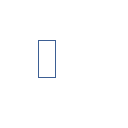
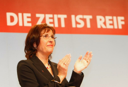
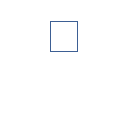
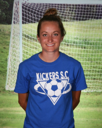
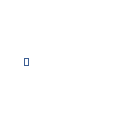
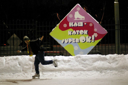

In [3]:
ds_train, ds_train_info = tfds.load('wider_face', split='train', shuffle_files=True, with_info=True)
ds_train = ds_train.filter(lambda x: len(x["faces"]["bbox"]) == 1) 
ds_test, ds_test_info = tfds.load('wider_face', split='test', shuffle_files=True, with_info=True)
ds_test = ds_test.filter(lambda x: len(x["faces"]["bbox"]) == 1) 
tfds.as_dataframe(ds_train.take(3), ds_train_info)

In [4]:
from tensorflow.image import resize
import numpy as np

def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""

  return tf.cast(resize(image, [224,224]),tf.float32) / 255., label

In [5]:
ds_train = ds_train.map(lambda x : normalize_img(image=x["image"], label=x["faces"]["bbox"]), num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_train_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

In [6]:
ds_test = ds_test.map(lambda x : normalize_img(image=x["image"], label=x["faces"]["bbox"]), num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.cache()
ds_test = ds_test.shuffle(ds_test_info.splits['test'].num_examples)
ds_test = ds_test.batch(128)
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

In [12]:
from akida_models import yolo_base, yolo_widerface_pretrained
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import Sequential

#layer, anchor = yolo_widerface_pretrained()
layer = yolo_base()
display(layer.summary())
layer.get_layer(index=-1)

Model: "yolo_base"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv_0 (Conv2D)             (None, 112, 112, 32)      864       
                                                                 
 conv_0/BN (BatchNormalizati  (None, 112, 112, 32)     128       
 on)                                                             
                                                                 
 conv_0/relu (ReLU)          (None, 112, 112, 32)      0         
                                                                 
 conv_1 (Conv2D)             (None, 112, 112, 64)      18432     
                                                         

None

In [13]:
model = Sequential()
model.add(layer)
model.add(Flatten())
model.add(Dense(4, activation='relu'))

In [14]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error"), 
              metrics=['accuracy'])
model.get_layer(index=-1)

In [17]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="./yolo_models",
                                                 save_weights_only=True,
                                                 verbose=1)

In [18]:
model.fit(
    ds_train,
    epochs=50,
    validation_data=ds_test,
    callbacks=[cp_callback]
)

Epoch 1/50
     32/Unknown - 212s 7s/step - loss: 0.0417 - accuracy: 0.7622